### Задание
Попробуйте поэкспериментировать со следующими параметрами нейронной сети:<br> 
1) кол-во слоев нейронной сети <br> 
2) кол-во нейронов в каждом слое <br>
3) функции активации на промежуточных слоях <br> 
4) кол-во фильтров в сверточном слое <br>
5) размер фильтра в сверточном слое <br>
6) размер окна в пулинг слое. <br>
<br>
<br>
Обучите нейронную сеть (полносвязную и сверточную) пробуя разные комбинации перечисленных выше параметров, <br> 
Составьте таблицу с зависимость точности нейронной сети на обучающих и тестовых данных, от значения параметра, <br>
Напишите Ваши выводы о том, как тот или иной параметр влияет на точность обучения нейронной сети.

In [1]:
import os 
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [2]:
import numpy as np                  
import matplotlib.pyplot as plt      
import random                        

from keras.datasets import mnist     # MNIST dataset 
from keras.models import Sequential  # Model Нейронной сети

from keras.layers.core import Dense, Dropout, Activation # Функции Активации и Слои нейронной сети
from keras.utils import np_utils                      

In [8]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
import tensorflow as tf

In [8]:
config=tf.ConfigProto(log_device_placement=True)

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [22]:
# Вспомогательная функция для расчета и вывода метрик
import sklearn
from sklearn import metrics
def calcMetrics(y_predict, y_true):
    return [metrics.accuracy_score(y_true, y_predict),
            metrics.precision_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.recall_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.f1_score(y_true, y_predict, average='weighted', zero_division=0)]
def printMetrics(m):
    print(f"Accuracy = {m[0]}, Precision = {m[1]}, Recall = {m[2]}, F1 = {m[3]}")

### Подготовка данных

In [50]:
#  60,000 28 x 28 pixel тренировочные изображения и  10,000 28 x 28 pixel тестовые изображения
(X_train_original, y_train_original), (X_test_original, y_test_original) = mnist.load_data()

print("X_train shape", X_train_original.shape)
print("y_train shape", y_train_original.shape)
print("X_test shape", X_test_original.shape)
print("y_test shape", y_test_original.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


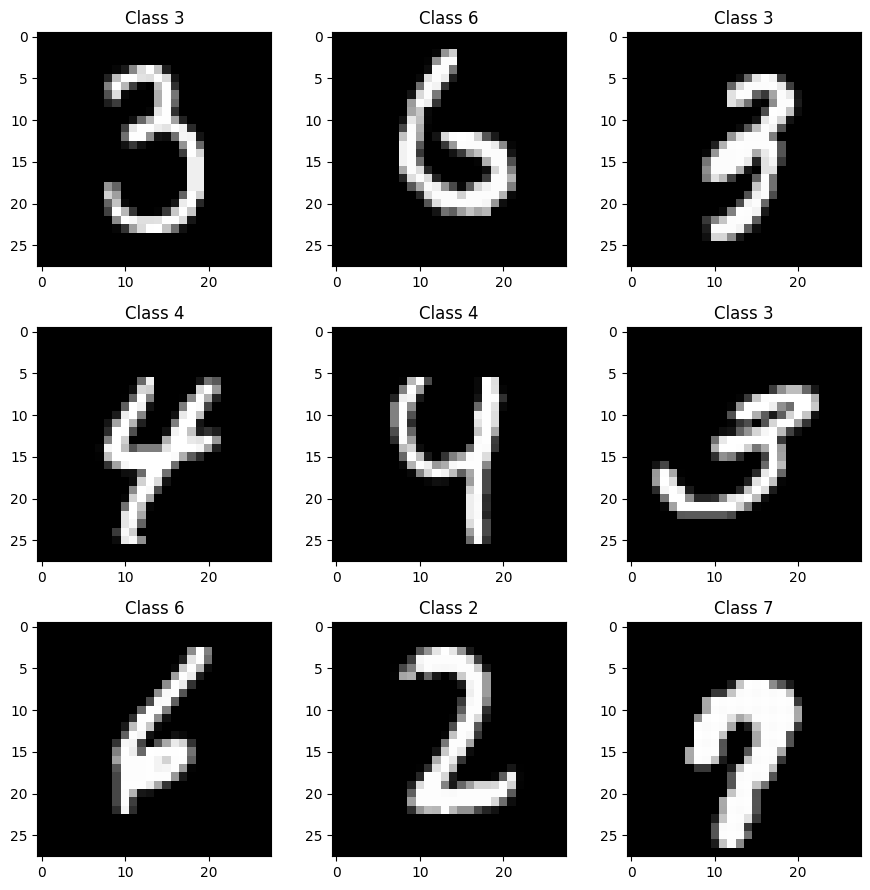

In [25]:
plt.rcParams['figure.figsize'] = (9,9) 

for i in range(9):
    plt.subplot(3, 3, i+1)
    num = random.randint(0, len(X_train_original))

    plt.imshow(X_train_original[num], cmap='gray', interpolation='none')
    plt.title(f"Class {y_train_original[num]}")
    
plt.tight_layout()

In [4]:
# вытягиваем в вектора
X_train = X_train_original.reshape(60000, 784) 
X_test = X_test_original.reshape(10000, 784)   

# конертируем в float
X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

X_train /= 255                       
X_test /= 255

In [52]:
# one-hot формат
nb_classes = 10 # Кол-во классов (всего 10 цифр)

Y_train = np_utils.to_categorical(y_train_original, nb_classes)
Y_test = np_utils.to_categorical(y_test_original, nb_classes)

### Модель полносвязной нейронной сети

In [6]:
model_full = Sequential()

# Первый слой
model_full.add(Dense(512, input_shape=(784,))) 
model_full.add(Activation('relu'))
model_full.add(Dropout(0.2)) # Dropout - это аналог регуляризации в нейронных сетях

# Второй слой
model_full.add(Dense(512))
model_full.add(Activation('relu'))
model_full.add(Dropout(0.2))

# Последний уровень FCN должен быть равен количеству желаемых классов (в данном случае 10).
model_full.add(Dense(10))
model_full.add(Activation('softmax'))

In [27]:
model_full.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

#### Сборка модели

Keras построен на основе Theano и TensorFlow. Оба пакета позволяют вам определять граф вычислений в Python, который затем компилируется и эффективно запускается на CPU или GPU без дополнительных затрат на интерпретатор Python.

При составлении модели Keras просит вас указать вашу функцию потерь и ваш оптимизатор. Функция потерь, которую мы здесь будем использовать, называется категориальной кросс-энтропией и является функцией потерь, хорошо подходящей для сравнения двух распределений вероятностей.

Оптимизатор помогает определить, насколько быстро модель обучается с помощью градиентного спуска. Скорость, с которой сходится градиент, называется скоростью обучения.

In [11]:
model_full.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size определяет, сколько данных на шаг используется для вычисления функции потерь, градиентов и обратного распространения. Большие размеры пакетов позволяют сети быстрее завершить обучение; Однако следует учитывать и другие факторы, помимо скорости тренировки.

Слишком большой размер batch_size пакета сглаживает локальные минимумы функции потерь, в результате чего оптимизатор застревает в Локальном минимуме.
Слишком маленький размер batch_siz пакета создает очень "зашумленную" функцию потерь, и оптимизатор может никогда не найти глобальный минимум.

epochs - количество итераций над каждым примером
verbose - вывод текстового прогресс бара 

#### Обучение

In [31]:
model_full.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1)

#### Предикт

In [13]:
Y_test_predicted = model_full.predict(X_test)
Y_test_predicted_c = np.argmax(Y_test_predicted, axis=1)

313/313 [==============================] - 0s 1ms/step


In [28]:
bEq = np.equal(Y_test_predicted_c, y_test_original)

In [29]:
np.unique(bEq, return_counts=True)

(array([False,  True]), array([ 183, 9817], dtype=int64))

#### Метрики валидационного набора

In [30]:
printMetrics(calcMetrics(Y_test_predicted_c, y_test_original))

Accuracy = 0.9817, Precision = 0.9817792609575706, Recall = 0.9817, F1 = 0.9817013156223915


### Модель сверточной нейронной сети

In [51]:
X_train_conv = X_train_original.reshape(60000, 28, 28, 1) 
X_test_conv = X_test_original.reshape(10000, 28, 28, 1)

X_train_conv = X_train_conv.astype('float32')         
X_test_conv = X_test_conv.astype('float32')

X_train_conv /= 255                              
X_test_conv /= 255

print("Training matrix shape", X_train_conv.shape)
print("Testing matrix shape", X_test_conv.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [41]:
# import 
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization.batch_normalization import BatchNormalization

In [54]:
model_conv = Sequential()                                 

# Сверточный слой 1
model_conv.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 РАЗНЫХ! 3x3 kernels -- это 32 карты с признаками
model_conv.add(BatchNormalization(axis=-1))                
convLayer01 = Activation('relu')                    
model_conv.add(convLayer01)

# Сверточный слой 2
model_conv.add(Conv2D(32, (3, 3)))                        
model_conv.add(BatchNormalization(axis=-1))               
model_conv.add(Activation('relu'))                        
convLayer02 = MaxPooling2D(pool_size=(2,2))          # MaxPool операция 2x2 kernel
model_conv.add(convLayer02)

# Сверточный слой 3
model_conv.add(Conv2D(64,(3, 3)))                         # 64 РАЗНЫХ! 3x3 kernels -- so 64 feature maps
model_conv.add(BatchNormalization(axis=-1))              
convLayer03 = Activation('relu')                     
model_conv.add(convLayer03)

# Сверточный слой 4
model_conv.add(Conv2D(64, (3, 3)))                        
model_conv.add(BatchNormalization(axis=-1))               
model_conv.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # MaxPool операция 2x2 kernel
model_conv.add(convLayer04)
model_conv.add(Flatten())                                 # Разворачиваем матрицу 4x4x64 в 1024-мерный плоский вектор

# Полносвязный слой 5
model_conv.add(Dense(512))                                # 512 нейронов
model_conv.add(BatchNormalization())               
model_conv.add(Activation('relu'))                      

# Полносвязный сло 6                       
model_conv.add(Dropout(0.2))                              # 20% dropout 
model_conv.add(Dense(10))                                 # выходной слой 10 нейронов
model_conv.add(Activation('softmax'))                     # softmax  (перевзвешивает все предсказания для получения значения в диапазоне 0..1)

In [55]:
model_conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_11 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 24, 24, 32)       

In [56]:
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
model_conv.fit(X_train_conv, Y_train,
          batch_size=32, epochs=10,
          verbose=1)

Epoch 1/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0838 - accuracy: 0.9734
Epoch 2/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0416 - accuracy: 0.9872
Epoch 3/10
1811/1875 [===========================>..] - ETA: 1s - loss: 0.0313 - accuracy: 0.9902

KeyboardInterrupt: 